In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import setup
import astropy.io.fits as fits
import csv
import pandas as pd

## Get data

In [4]:
datadir = setup.data_home_dir()

#SPT
sptpol100d_file = datadir + '/spt_catalogs/sptpol100d_catalog_huang19.csv'

#DES--redMaPPer full run vl50
#redMaPPer_file = datadir + 'y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt5_vl50_catalog.fit'
#DES--redMaPPer cosmology run vl02
#redMaPPer_file = datadir + 'y3_gold_2.2.1_wide_sofcol_run2_redmapper_v.6.4.22+2_lgt20_vl02_catalog.fit'
#DES--redMaPPer random run
redMaPPer_file = datadir + '/redMaPPer/y3_gold_2.2.1_wide_sofcol_run2_y3_random_locations_100_runpos.csv'

In [5]:
spt_data = pd.read_csv(sptpol100d_file)
redM_data = pd.read_csv(redMaPPer_file)

## Testing properties of the files. 

In [6]:
#SPT data
print("Number of SPT clusters:", len(spt_data))
print(spt_data.columns.values,"\n")

#z > 0 cut
spt_data = spt_data[spt_data.redshift >= 0]
print("After z cut number of SPT clusters is ", len(spt_data))

#redM_data = redM_data[redM_data.Z_LAMBDA >= 0]
print("After z cut number of redMaPPER clusters is ", len(redM_data))



Number of SPT clusters: 79
['SPT_ID' 'RA' 'Dec' 'xi' 'theta_core' 'redshift' 'redshift_unc' 'M500'
 'M500_lerr' 'M500_uerr' 'imaging' 'P_blank' 'field'] 

After z cut number of SPT clusters is  79
After z cut number of redMaPPER clusters is  113100


Number of DES clusters: 113100


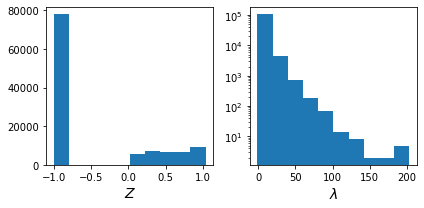

In [7]:
print("Number of DES clusters:", len(redM_data))

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(6,3))
subtitles = [r'$Z$', r'$\lambda$']

nbins=10

axs[0].hist(redM_data.Z_LAMBDA, bins=nbins)
axs[1].hist(redM_data.LAMBDA_CHISQ, bins=nbins)
axs[1].set_yscale('log')

for i in range(2):
    axs[i].set_xlabel(subtitles[i], size=14)

#plt.savefig('richness_mass_modelparams_cosibinned_060718.png')
plt.show()

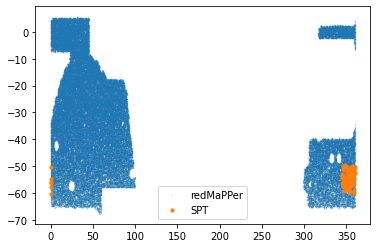

In [8]:
plt.scatter(redM_data.RA, redM_data.DEC, s=0.1, alpha=0.3, label='redMaPPer')
plt.scatter(spt_data.RA, spt_data.Dec, s=10, label='SPT')
plt.legend()
plt.show()

In [9]:
##Cumulative fraction lambda < x
qf = []
for x in np.linspace(0,50,101):
    sel = (redM_data['Z_LAMBDA']>0) & (redM_data['LAMBDA_CHISQ'] > x)
    qf.append(len(redM_data.loc[sel])/len(redM_data))
    
qf = np.array(qf)

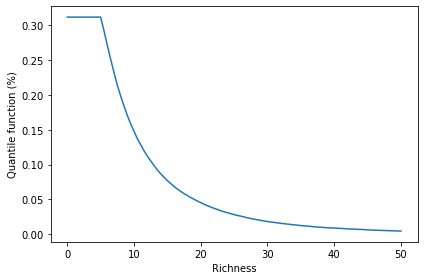

In [10]:
x = np.linspace(0,50,101)
plt.figure(tight_layout=True)
plt.plot(x, qf)
plt.xlabel('Richness')
plt.ylabel('Quantile function (%)')
plt.savefig('RM_random_match.png')
plt.show()

## Coordinate matching

In [11]:
#Coordinate
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

#Using find_nearest iterate through the array and find index of matched ones, also index of unmatched. 
redM_coord = SkyCoord(redM_data.RA.values*u.deg, redM_data.DEC.values*u.deg,  frame='icrs')
spt_coord = SkyCoord(spt_data.RA.values*u.deg, spt_data.Dec.values*u.deg, frame='icrs')
print("Completed measuring coordinates")

Completed measuring coordinates


In [35]:
#Add a new column on redMaPPer candidate ID
spt_data['redM_candidate_ID'] = [[] for _ in range(len(spt_data))]
spt_data['redM_richness'] = [[] for _ in range(len(spt_data))]
spt_data['Z_redM'] = [[] for _ in range(len(spt_data))]
spt_data['MASKFRAC_redM'] = [[] for _ in range(len(spt_data))]
spt_data['Dprop_sep'] = [[] for _ in range(len(spt_data))]

###Testing the code. 
#spt_data = spt_data['redM_candidate_ID'].astype(object)
#spt_data = spt_data.drop('Z_REDM', axis=1)
#spt_data = spt_data.drop('MASKFRAC_REDM', axis=1)
#spt_data.at[0,'redM_candidate_ID'] = [1 1 1 1]
#spt_data.loc[0]
spt_data.dtypes

SPT_ID                object
RA                   float64
Dec                  float64
xi                   float64
theta_core           float64
redshift             float64
redshift_unc         float64
M500                 float64
M500_lerr            float64
M500_uerr            float64
imaging                int64
P_blank              float64
field                 object
redM_candidate_ID     object
redM_richness         object
Z_redM                object
MASKFRAC_redM         object
Dprop_sep             object
dtype: object

In [36]:
#For Each SPT Cluster find a list of redMaPPer candidates
##TODO: Find RedMapper candidates for each SPT cluster. 
matching_dist = 500 #kpc/h
for i in range(len(spt_coord)):
    ang_sep = redM_coord.separation(spt_coord[i]).value #In degrees
    propD_sep = (cosmo.kpc_proper_per_arcmin(spt_data.redshift[i])*ang_sep*60).value
    propD_sep_cut_idx = np.where(propD_sep < matching_dist)
    redM_matching_candidate_ID = redM_data.iloc[propD_sep_cut_idx].MEM_MATCH_ID
    propD_sep_cut = propD_sep[propD_sep_cut_idx]
    
    #Combine RedMaPPer properties. 
    redM_matching_candidate_ID = list(redM_matching_candidate_ID)
    spt_data.at[i,'redM_candidate_ID'] = list(redM_matching_candidate_ID)
    spt_data.at[i,'Dprop_sep'] = list(propD_sep_cut)
    #if len(redM_matching_candidate_ID) > 0:
    #    spt_data.at[i,'redM_richness'] = redM_data.loc[redM_matching_candidate_ID, ['LAMBDA_CHISQ']].values
    #    spt_data.at[i,'Z_RedM'] = redM_data.loc[redM_matching_candidate_ID, ['Z']]
    #    spt_data.at[i,'MASKFRAC_RedM'] = redM_data.loc[redM_matching_candidate_ID, ['MASKFRAC']]
    #print(len(redM_matching_candidate_ID))
print("Done")

Done


In [37]:
#Plotting redMaPPer richness, find redMaPPer with the highest richness.
#Need to rerun coordinate matching every time you run this code. 
for i in range(len(spt_data)):
    id_list = spt_data.loc[i, 'redM_candidate_ID']
    if len(id_list) > 0:
        sel = redM_data['MEM_MATCH_ID'].isin(id_list)
        richness = redM_data.loc[sel, 'LAMBDA_CHISQ'].values
        
        #Find the redMaPPer candidate with the LOWEST richness
        bestmatch_ind = np.argsort(richness)[0]
        bestmatch_id = id_list[bestmatch_ind]
        
        #pick among many the best candidate
        sel = redM_data['MEM_MATCH_ID'].eq(bestmatch_id)
        
        mem_match_id = redM_data.loc[sel, 'MEM_MATCH_ID'].values
        richness = float(redM_data.loc[sel, 'LAMBDA_CHISQ'].values)
        z_redm = float(redM_data.loc[sel, 'Z_LAMBDA'].values)
        maskfrac_redm = float(redM_data.loc[sel, 'MASKFRAC'].values)
        dprop_sep = spt_data.loc[i,'Dprop_sep'][bestmatch_ind]
        
        spt_data.at[i,'redM_candidate_ID'] = mem_match_id
        spt_data.at[i,'redM_richness'] = richness
        spt_data.at[i,'Z_redM'] = z_redm
        spt_data.at[i,'MASKFRAC_redM'] = maskfrac_redm
        spt_data.at[i,'Dprop_sep'] = dprop_sep
print("Done")

Done


## Plotting

In [38]:
#find matched
#Figure out how to create a boolean condition for redM_candidate_ID
matched_idx = [bool(spt_data['redM_candidate_ID'][i]) for i in range(len(spt_data))]

[]

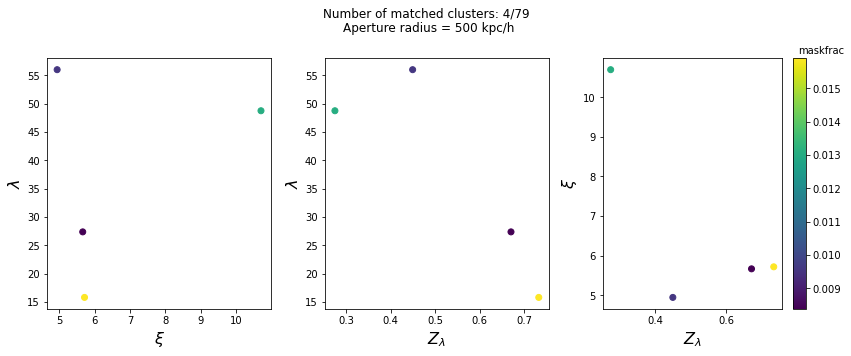

In [39]:
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12,5))
axs[0].scatter(spt_data.loc[matched_idx, 'xi'], spt_data.loc[matched_idx, 'redM_richness'], c=spt_data.loc[matched_idx, 'MASKFRAC_redM'])
axs[1].scatter(spt_data.loc[matched_idx, 'Z_redM'], spt_data.loc[matched_idx, 'redM_richness'], c=spt_data.loc[matched_idx, 'MASKFRAC_redM'])
sc = axs[2].scatter(spt_data.loc[matched_idx, 'Z_redM'], spt_data.loc[matched_idx, 'xi'], c=spt_data.loc[matched_idx, 'MASKFRAC_redM'])

#labels
axs[0].set_xlabel(r'$\xi$', fontsize=16); axs[0].set_ylabel(r'$\lambda$', fontsize=16)
axs[1].set_xlabel(r'$Z_{\lambda}$', fontsize=16); axs[1].set_ylabel(r'$\lambda$', fontsize=16)
axs[2].set_xlabel(r'$Z_{\lambda}$', fontsize=16); axs[2].set_ylabel(r'$\xi$', fontsize=16)
plt.suptitle("Number of matched clusters: {:d}/{:d} \n".format(len(spt_data.loc[matched_idx]), len(spt_data)) + "Aperture radius = {:.0f} kpc/h".format(matching_dist))

cbar = plt.colorbar(sc)
cbar.set_label('maskfrac', labelpad=-20, y=1.05, rotation=0)
plt.plot()

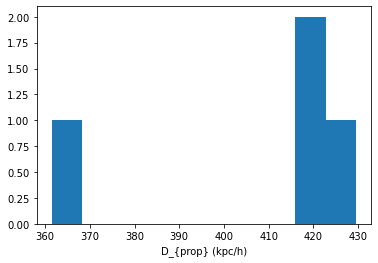

In [40]:
plt.hist(spt_data.loc[matched_idx, 'Dprop_sep'])
plt.xlabel('D_{prop} (kpc/h)')
plt.show()